In [1]:
# imports
import os
import pathlib
import csv
import pickle
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#!pip3 install opencv-python # uncomment if cv2 isnt available
import cv2
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.metrics import classification_report
import seaborn as sns
import tqdm

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#!pip3 install xgboost # uncomment if xgboost isnt available
from xgboost import XGBClassifier

# Read and analyse the data

In [3]:
def read_data(root_path):
    features = []
    labels = []
    path = pathlib.Path(root_path)
    for f_name in path.glob('*/*.csv'):
        current_dir = pathlib.Path(f_name).parent
        with open(f_name) as f:
            csv_reader = csv.reader(f, delimiter=';')
            next(csv_reader) # to avoid the headers
            for row in csv_reader:
                features.append(plt.imread(os.path.join(current_dir, row[0])))
                labels.append(row[7])
    return np.array(features), np.array(labels).astype(np.int8)

In [4]:
%%time

# read the data
train_dir = './data/GTSRB/training/Images/'
test_dir = './data/GTSRB/test/Images/'

train_features, train_labels = read_data(train_dir)
test_features, test_labels = read_data(test_dir)

# shuffle the data
train_features, train_labels = shuffle(train_features, train_labels, random_state=0)
test_features, test_labels = shuffle(test_features, test_labels, random_state=0)

CPU times: user 4.61 s, sys: 580 ms, total: 5.19 s
Wall time: 5.19 s


In [5]:
print(f'Number of training examples = {train_features.shape[0]}')
print(f'Number of testing examples = {test_features.shape[0]}')
print(f'Number of different shapes = {len(set([img.shape for img in train_features]))}')
print(f'Pixel range = [{np.min(train_features[0])}, {np.max(train_features[0])}]')
print(f'Number of classes = {len(set(train_labels))}')

Number of training examples = 39209
Number of testing examples = 12569
Number of different shapes = 2924
Pixel range = [19, 255]
Number of classes = 43


<BarContainer object of 43 artists>

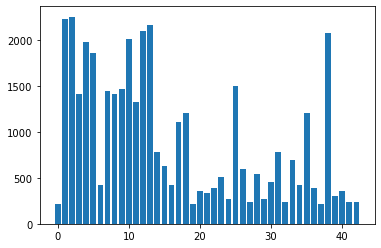

In [6]:
class_distribution = []
for c in set(train_labels):
    class_distribution.append([c, train_labels[train_labels==c].shape[0]])
class_distribution = np.array(class_distribution)
plt.bar(class_distribution[:,0], class_distribution[:,1])

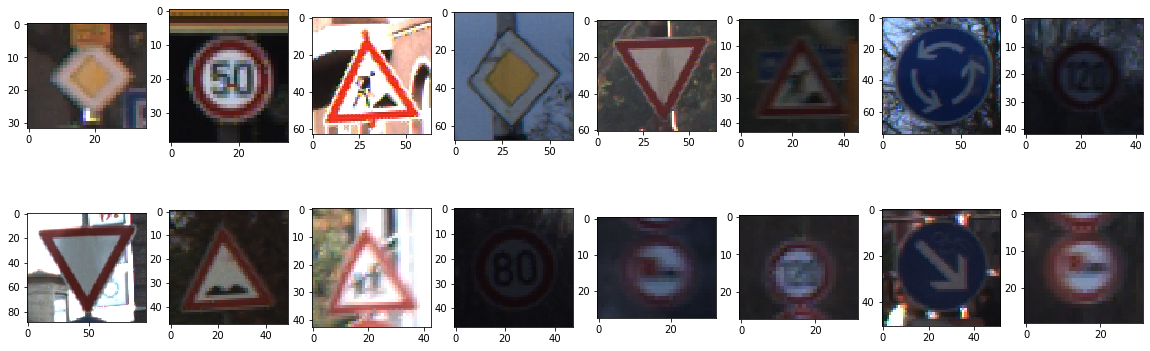

In [7]:
n_images = 16
cols = 8
rows = int(n_images/cols)+1
plt.figure(figsize=(20,10))
for i in range(n_images):
    plt.subplot(rows, cols, i+1)
    plt.imshow(train_features[i])
plt.show()

In [8]:
%%time


def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def preprocess(features, labels):
    # homogenize the size to 32x32, normalize the image and make it flat
    img_size = (32, 32)
    return np.array([normalize(cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)).flatten() for img in features]), labels.flatten()

X_train, y_train = preprocess(train_features, train_labels)
X_test, y_test = preprocess(test_features, test_labels)

CPU times: user 4.2 s, sys: 372 ms, total: 4.57 s
Wall time: 4.57 s


In [9]:
# now they are normalize and with the correct size
print(X_test.shape) # 32x32x3
print(np.mean(X_test[0]))
print(np.std(X_test[0]))

(12569, 3072)
0.0
1.0


# Code for experiments

In [10]:
def experiments(models, X_train, y_train, X_test, y_test, scoring='accuracy'):
    classifi_rep = {}
    cross_val_data = []
    
    for name, model in models.items():
        print(f'########################## {name} ##########################')
        # cross-validation
        cross_val_results = model_selection.cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
        this_df = pd.DataFrame(cross_val_results)
        this_df['model'] = name
        cross_val_data.append(this_df)
        print(name)
        print(this_df)
        # test the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        classifi_rep[name] = classification_report(y_test, y_pred, output_dict=False)
        print(classifi_rep[name])

    return pd.concat(cross_val_data, ignore_index=True), classifi_rep

In [11]:
def report(models, cross_val):
    # create more data for the statistics
    bootstraps = []
    for model in models.keys():
        model_df = cross_val.loc[cross_val.model == model]
        bootstrap = model_df.sample(n=30, replace=True)
        bootstraps.append(bootstrap)
    # joint everything
    bootstrap_df = pd.concat(bootstraps, ignore_index=True)
    
    
    results_long = pd.melt(bootstrap_df, id_vars=['model'], var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time']
    # performance metrics
    results_long_pm = results_long.loc[~results_long['metrics'].isin(time_metrics)]
    #results_long_pm = results_long_pm.sort_values(by='values')
    results_long_ft = results_long.loc[results_long['metrics'].isin(time_metrics)]
    #results_long_ft = results_long_ft.sort_values(by='values')
    
    print('########################## Performance ##########################')
    
    # means and stds for each metric
    metrics = list(set(results_long_pm.metrics.values))
    display(bootstrap_df.groupby(['model'], sort = False)[metrics].agg([np.std, np.mean]))
    
    # First, let’s plot our performance metrics from the 5-fold cross validation.

    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.5)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_pm, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of Model by Classification Metric')
    plt.savefig('./benchmark_models_performance.png',dpi=300)
    plt.show()
    
    
    print('########################## Time ##########################')
    
    # means and stds for times
    time_metrics = list(set(results_long_ft.metrics.values))
    display(bootstrap_df.groupby(['model'], sort = False)[time_metrics].agg([np.std, np.mean]))
    
    # training and scoring times
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.5)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_ft, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of Model by Fit and Score Time')
    plt.savefig('./benchmark_models_time.png',dpi=300)
    plt.show()

In [12]:
def analysis(models, exp_name='', force=False):

    # path where to save results
    comparison_path = os.path.join('./results/', exp_name + '.pckl')

    if os.path.exists(comparison_path) and not force:
        # load the results
        with open(comparison_path, 'rb') as f:
            models, cross_val, classifi_rep = pickle.load(f)
    else:
        scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
        cross_val, classifi_rep  = experiments(models, X_train, y_train, X_test, y_test, scoring)

        # save results
        with open(comparison_path, 'wb') as f:
            pickle.dump([models, cross_val, classifi_rep], f)
    
    for name, rep in classifi_rep.items():
        print(f'########################## {name} ##########################')
        print(rep)
        
    report(models, cross_val)

# DELETE!!!!!!!!!!!!!!!!!!

In [13]:
##################  DELETE ###########################
# this is just to develop



use_small_data = True
if use_small_data:
    X_train, X_test, y_train, y_test = X_train[:100], X_test[:10], y_train[:100], y_test[:10]

# Others

########################## LogReg ##########################


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `

LogReg
   fit_time  score_time  test_accuracy  test_precision_macro  \
0  1.501362    0.016009           0.30              0.174603   
1  1.142392    0.006908           0.35              0.180159   
2  1.136078    0.006466           0.40              0.247619   
3  1.119576    0.006758           0.30              0.219298   
4  1.151675    0.003279           0.40              0.305882   

   test_recall_macro  test_f1_macro   model  
0           0.214286       0.180952  LogReg  
1           0.285714       0.201587  LogReg  
2           0.333333       0.269841  LogReg  
3           0.236842       0.226316  LogReg  
4           0.382353       0.320728  LogReg  


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


              precision    recall  f1-score   support

           1       0.25      1.00      0.40         1
           2       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         2
          10       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         2
          33       0.00      0.00      0.00         0
          34       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         0

    accuracy                           0.30        10
   macro avg       0.20      0.23      0.19        10
weighted avg       0.33      0.30      0.27        10

########################## RF ##########################


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is 

RF
   fit_time  score_time  test_accuracy  test_precision_macro  \
0  0.600879    0.113745           0.25              0.133333   
1  0.297994    0.114156           0.25              0.163743   
2  0.288397    0.113937           0.20              0.097500   
3  0.344334    0.114779           0.25              0.171053   
4  0.340478    0.114892           0.25              0.100000   

   test_recall_macro  test_f1_macro model  
0           0.222222       0.161376    RF  
1           0.236842       0.168421    RF  
2           0.150000       0.100000    RF  
3           0.184211       0.175439    RF  
4           0.205882       0.132493    RF  


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with n

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         1
           8       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         2
          28       0.00      0.00      0.00         0
          34       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         0

    accuracy                           0.30        10
   macro avg       0.30      0.20      0.23        10
weighted avg       0.50      0.30      0.37        10

########################## KNN ##########################


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is 

KNN
   fit_time  score_time  test_accuracy  test_precision_macro  \
0  0.004757    0.140661           0.25              0.111111   
1  0.017378    0.140073           0.20              0.094104   
2  0.009259    0.151511           0.15              0.119048   
3  0.015955    0.035394           0.20              0.144737   
4  0.004714    0.141019           0.20              0.062500   

   test_recall_macro  test_f1_macro model  
0           0.222222       0.137037   KNN  
1           0.190476       0.115079   KNN  
2           0.119048       0.119048   KNN  
3           0.157895       0.140351   KNN  
4           0.138889       0.085185   KNN  
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         2
          10       0.5

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with n

SVM
   fit_time  score_time  test_accuracy  test_precision_macro  \
0  0.084857    0.008322           0.25              0.139122   
1  0.064861    0.007150           0.15              0.043162   
2  0.069817    0.007379           0.20              0.041667   
3  0.062147    0.007116           0.30              0.162656   
4  0.064640    0.008288           0.15              0.052679   

   test_recall_macro  test_f1_macro model  
0           0.235294       0.153743   SVM  
1           0.166667       0.063492   SVM  
2           0.166667       0.065873   SVM  
3           0.264706       0.169080   SVM  
4           0.125000       0.065972   SVM  
              precision    recall  f1-score   support

           1       0.20      1.00      0.33         1
           2       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
          10       1.00      1.00      1.00         1
          12       0.0

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with n

[02:33:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[02:34:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:38:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:40:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test_accuracy           test_f1_macro           test_recall_macro  \
                 std      mean           std      mean               std   
model                                                                      
LogReg      0.047222  0.336667      0.054807  0.235928          0.069376   
RF          0.022489  0.236667      0.029465  0.143009          0.032587   
KNN         0.039392  0.200000      0.019259  0.118563          0.043639   
SVM         0.059427  0.201667      0.046206  0.094852          0.052065   
GNB         0.086586  0.131667      0.067188  0.072760          0.092861   
XGB         0.049827  0.260000      0.029302  0.159514          0.034502   

                 test_precision_macro            
            mean                  std      mean  
model                                            
LogReg  0.276183             0.051531  0.224826  
RF      0.197121             0.028844  0.127306  
KNN     0.166082             0.023878  0.103744  
SVM     0.182026             0.051138  0.078846  
GNB     0.129807             0.058078  0.064034  
XGB     0.220345             0.031771  0.141788

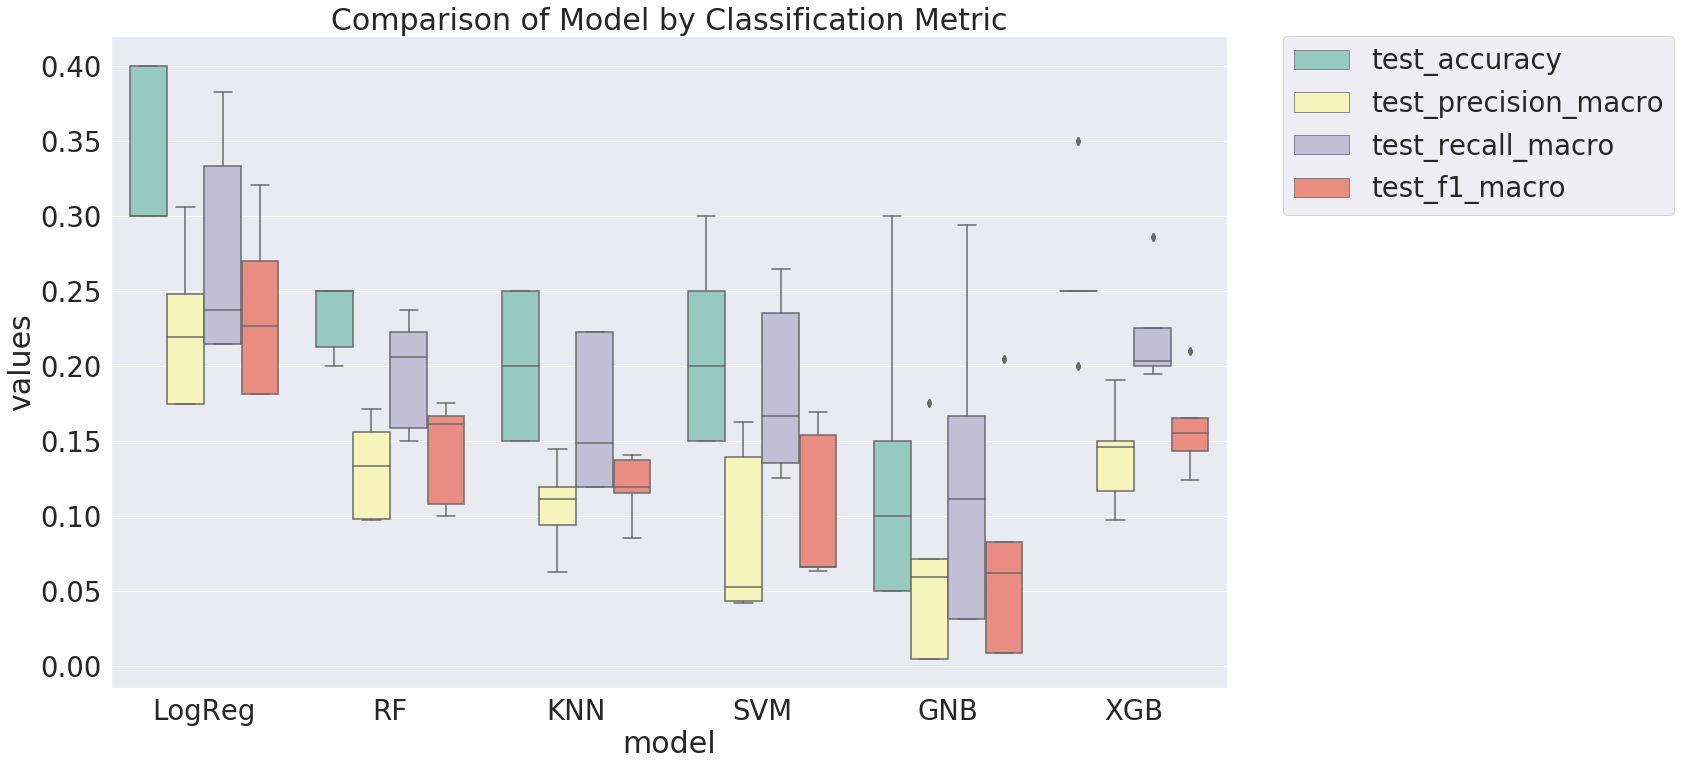

########################## Time ##########################


score_time             fit_time            
              std      mean        std        mean
model                                             
LogReg   0.005214  0.009011   0.175773    1.257499
RF       0.000460  0.114180   0.135766    0.399559
KNN      0.028038  0.136891   0.004711    0.008528
SVM      0.000535  0.007617   0.006487    0.067415
GNB      0.000404  0.008858   0.000162    0.003792
XGB      0.000240  0.008021  12.808497  117.671657

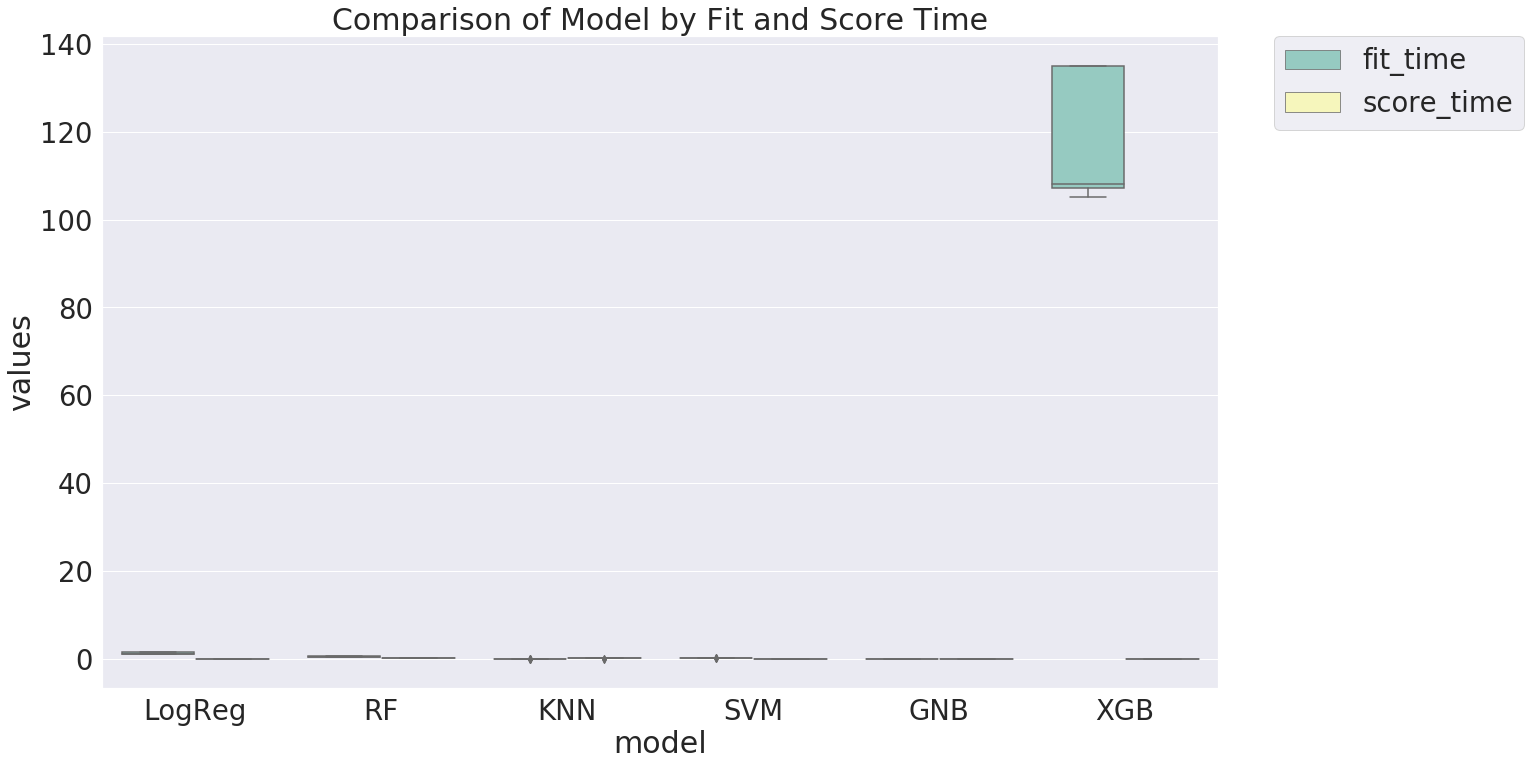

CPU times: user 1h 3min 59s, sys: 4.78 s, total: 1h 4min 4s
Wall time: 12min 2s


In [14]:
%%time

models = {'LogReg': LogisticRegression(n_jobs=12), 
          'RF': RandomForestClassifier(n_jobs=12),
          'KNN': KNeighborsClassifier(n_jobs=12),
          'SVM': SVC(), 
          'GNB': GaussianNB(),
          'XGB': XGBClassifier(objective='multi:softmax', n_jobs=12, tree_method='gpu_hist', gpu_id=0)}
analysis(models, 'others')

# XGBoost

In [ ]:
%%time
basic = XGBClassifier(gamma=0.5,
                      learning_rate=0.01, 
                      max_delta_step=0.1, 
                      max_depth=5,
                      min_child_weight=0.2,
                      n_estimators=100,
                      objective='multi:softmax',
                      reg_alpha=0.5,
                      reg_lambda=0.8, 
                      scale_pos_weight=1, 
                      subsample=0.8,
                      n_jobs=12, 
                      gpu_id=0, 
                      tree_method='gpu_hist',
                      validate_parameters=True,
                      verbosity=1)

n_estimators = [10, 50, 100]
models = {}
for n in n_estimators:
    m = copy.deepcopy(basic)
    m.n_estimators = n
    models['n_estimators_' + str(n)] = m

analysis(models, 'xgb_estimators')

In [ ]:
%%time
basic = XGBClassifier(gamma=0.5,
                      learning_rate=0.01, 
                      max_delta_step=0.1, 
                      max_depth=5,
                      min_child_weight=0.2,
                      n_estimators=50,
                      objective='multi:softmax',
                      reg_alpha=0.5,
                      reg_lambda=0.8, 
                      scale_pos_weight=1, 
                      subsample=0.8,
                      n_jobs=12, 
                      gpu_id=0, 
                      tree_method='gpu_hist',
                      validate_parameters=True,
                      verbosity=1)

learning_rate = [0.1, 0.01, 0.001]
models = {}
for n in learning_rate:
    m = copy.deepcopy(basic)
    m.learning_rate = n
    models['learning_rate_' + str(n)] = m

analysis(models, 'xgb_learning_rate')

In [ ]:
%%time
basic = XGBClassifier(gamma=0.5,
                      learning_rate=0.01, 
                      max_delta_step=0.1, 
                      max_depth=5,
                      min_child_weight=0.2,
                      n_estimators=50,
                      objective='multi:softmax',
                      reg_alpha=0.5,
                      reg_lambda=0.8, 
                      scale_pos_weight=1, 
                      subsample=0.8,
                      n_jobs=12, 
                      gpu_id=0, 
                      tree_method='gpu_hist',
                      validate_parameters=True,
                      verbosity=1)

max_depth = [5, 10, 20]
models = {}
for n in max_depth:
    m = copy.deepcopy(basic)
    m.max_depth = n
    models['max_depth_' + str(n)] = m

analysis(models, 'xgb_max_depth')

In [ ]:
%%time
basic = XGBClassifier(gamma=0.5,
                      learning_rate=0.01, 
                      max_delta_step=0.1, 
                      max_depth=5,
                      num_parallel_tree=None,
                      min_child_weight=0.2,
                      n_estimators=50,
                      objective='multi:softmax',
                      reg_alpha=0.5,
                      reg_lambda=0.8, 
                      scale_pos_weight=1, 
                      subsample=0.8,
                      n_jobs=12, 
                      gpu_id=0, 
                      tree_method='gpu_hist',
                      validate_parameters=True,
                      verbosity=1)

num_parallel_tree = [1, 5, 10]
models = {}
for n in num_parallel_tree:
    m = copy.deepcopy(basic)
    m.num_parallel_tree = n
    models['num_parallel_tree_' + str(n)] = m